<a href="https://colab.research.google.com/github/ahmadcah/Hukumpedia/blob/master/Google_Colab/Prototype_Capstone_Project_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
import tensorflow as tf
import numpy as np 
import string

In [3]:
realCorpus = []
with open('/content/drive/MyDrive/MergedData.txt', 'rb') as f:
  data = ''.join([x.decode('utf-8') for x in f.readlines()])
  data = data.lower().replace('\n', '').replace('\r', '').replace('\ufeff', '')
data[:400]

'                           deklarasi universal                          hak-hak asasi manusia                         diterima dan diumumkan oleh majelis umum pbb                     pada tanggal 10 desember 1948 melalui resolusi 217 a (iii)                                          mukadimahmenimbang, bahwa pengakuan atas martabat alamiah dan hak-hak yang sama dan tidak dapatdicabut dari semua ang'

In [13]:
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
new_data = data.translate(translator)
splitData = new_data.split()
splitDataLength = len(splitData)
print(splitDataLength)

559754


In [14]:
temp = []
for i in splitData:
  if i not in temp:
    temp.append(i)
print(len(temp))

33014


In [15]:
data_train = []
previous = 0
for i in range(0,len(temp)-1,2):
  data_train.append(' '.join(temp[previous:i]))
  previous = i


In [16]:
data_train[:8]

['',
 'deklarasi universal',
 'hak asasi',
 'manusia diterima',
 'dan diumumkan',
 'oleh majelis',
 'umum pbb',
 'pada tanggal']

In [17]:
tokenizer = Tokenizer(oov_token='oov')
tokenizer.fit_on_texts(data_train)

In [8]:
import pickle

with open('/content/drive/MyDrive/Bangkit Capstone/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
import io,json

tokenizer_json = tokenizer.to_json()
with io.open('/content/drive/MyDrive/Bangkit Capstone/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [18]:
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in data_train:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
label = tf.keras.utils.to_categorical(label, num_classes=total_words)

In [20]:
model = Sequential()
model.add(Embedding(total_words, 250, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(500, return_sequences=True)))
model.add(Bidirectional(LSTM(500)))
model.add(Dropout(0.2))
model.add(Dense(1000, activation="relu"))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 250)            8253500   
_________________________________________________________________
bidirectional (Bidirectional (None, 1, 1000)           3004000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1000)              6004000   
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 1000)              1001000   
_________________________________________________________________
dense_1 (Dense)              (None, 33014)             33047014  
Total params: 51,309,514
Trainable params: 51,309,514
Non-trainable params: 0
__________________________________________

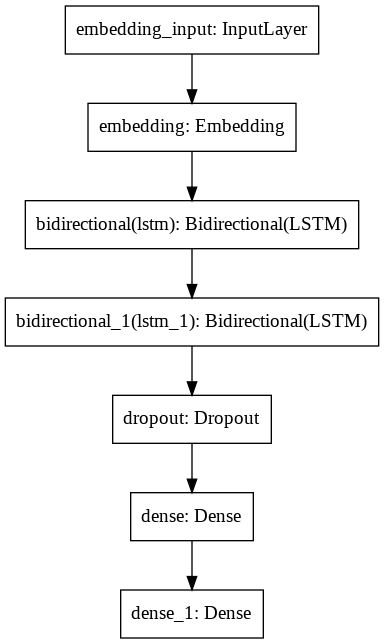

In [21]:
tf.keras.utils.plot_model(model, to_file='/content/drive/MyDrive/Bangkit Capstone/model.png', show_layer_names=True)

In [22]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.98):
      self.model.stop_training = True

#checkpoint = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Bangkit Capstone/checkpoint/model", monitor='loss', verbose=1,save_best_only=True, mode='auto')

reduceLoss = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)
callbacksEarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
preventOverfit = myCallback()

In [23]:
history = model.fit(predictors, label, epochs=500, batch_size=64, verbose=1, callbacks=[preventOverfit,callbacksEarlyStopping,reduceLoss])

Epoch 1/500
258/258 [==============================] - 31s 56ms/step - loss: 10.4284 - accuracy: 0.0000e+00
Epoch 2/500
258/258 [==============================] - 14s 54ms/step - loss: 10.2949 - accuracy: 0.0000e+00
Epoch 3/500
258/258 [==============================] - 14s 55ms/step - loss: 9.7695 - accuracy: 0.0000e+00
Epoch 4/500
258/258 [==============================] - 14s 55ms/step - loss: 9.3731 - accuracy: 0.0000e+00
Epoch 5/500
258/258 [==============================] - 14s 54ms/step - loss: 8.7317 - accuracy: 6.0584e-04
Epoch 6/500
258/258 [==============================] - 14s 56ms/step - loss: 8.0982 - accuracy: 0.0027
Epoch 7/500
258/258 [==============================] - 14s 55ms/step - loss: 7.6199 - accuracy: 0.0065
Epoch 8/500
258/258 [==============================] - 14s 55ms/step - loss: 7.2047 - accuracy: 0.0163
Epoch 9/500
258/258 [==============================] - 14s 55ms/step - loss: 6.8436 - accuracy: 0.0257
Epoch 10/500
258/258 [=============================

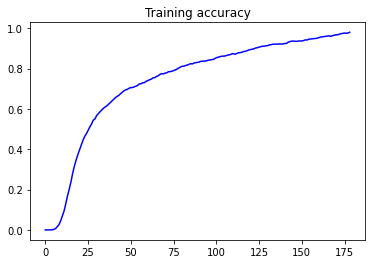

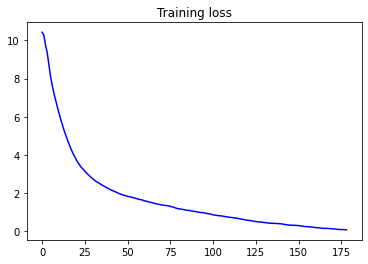

In [24]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')


plt.show()

In [25]:
text = "bentuk"
print('input: '+text)
print('nomor itu accuracy')

token_list = tokenizer.texts_to_sequences([text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

predictions = model.predict(token_list)

indices = np.argpartition(predictions, -10)[0][-10:]

results = {}
for index in indices:
  key = [k for (k, v) in tokenizer.word_index.items() if v == index]
  results.update({key[0]: predictions[0, index]})

  results = {k: v for k, v in sorted(results.items(), key=lambda item: item[1], reverse=True)}

print("{}".format(results))
for i in results:
  print(text+" "+i)

input: bentuk
nomor itu accuracy
{'mesti': 0.99967134, '655barangsiapa': 0.00030759815, 'tersebutjika': 1.485445e-05, 'secaratidak': 4.5887923e-06, 'lanjuti': 3.2407465e-07, 'kuasaannya': 2.360026e-07, '815hak': 1.8062396e-07, 'kapalpasal': 1.6093489e-07, 'keuntunganapa': 1.5516446e-07, 'penggulingan': 1.0209996e-07}
bentuk mesti
bentuk 655barangsiapa
bentuk tersebutjika
bentuk secaratidak
bentuk lanjuti
bentuk kuasaannya
bentuk 815hak
bentuk kapalpasal
bentuk keuntunganapa
bentuk penggulingan


In [26]:
model.save('/content/model/saved_prototype_model/my_model')

INFO:tensorflow:Assets written to: /content/model/saved_prototype_model/my_model/assets


INFO:tensorflow:Assets written to: /content/model/saved_prototype_model/my_model/assets


In [27]:
model.save('/content/model/saved_prototype_model_HDF5/my_model.h5')

In [28]:
import pathlib

In [29]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/model/saved_prototype_model/my_model')
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

In [30]:
tflite_model_file = pathlib.Path('./model/modelSizeOptimize.tflite')
tflite_model_file.write_bytes(tflite_model)

51506528

In [31]:
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
tflite_model = converter.convert()
tflite_model_file = pathlib.Path('./model/modelLatencyOptimize.tflite')
tflite_model_file.write_bytes(tflite_model)

51506528

In [32]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
tflite_model_file = pathlib.Path('./model/modelDefaultOptimize.tflite')
tflite_model_file.write_bytes(tflite_model)

51506528

In [33]:
!zip -r /content/Model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/modelSizeOptimize.tflite (deflated 51%)
  adding: content/model/modelLatencyOptimize.tflite (deflated 51%)
  adding: content/model/modelDefaultOptimize.tflite (deflated 51%)
  adding: content/model/saved_prototype_model/ (stored 0%)
  adding: content/model/saved_prototype_model/my_model/ (stored 0%)
  adding: content/model/saved_prototype_model/my_model/variables/ (stored 0%)
  adding: content/model/saved_prototype_model/my_model/variables/variables.data-00000-of-00001 (deflated 25%)
  adding: content/model/saved_prototype_model/my_model/variables/variables.index (deflated 69%)
  adding: content/model/saved_prototype_model/my_model/assets/ (stored 0%)
  adding: content/model/saved_prototype_model/my_model/keras_metadata.pb (deflated 92%)
  adding: content/model/saved_prototype_model/my_model/saved_model.pb (deflated 91%)
  adding: content/model/saved_prototype_model_HDF5/ (stored 0%)
  adding: content/model/saved_prototype_mo